## Introduction

**This is a notebook to pre-process and start working on the Kaggle Data Science Bowl 2017 dataset.**

Working with bio-medical imaging files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by a machine learning or deep-learning model.


**This tutorial provides an overview of useful steps to pre-process the data before applying various machine learning techniques.**

This noteboos covers the following topics:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.


---

## Import libraries:

**Import the necessary python libraries**

In [46]:
%matplotlib inline

import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology, measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
# Some constants 
INPUT_FOLDER = './kaggle/train/stage1/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print ("Total number of scans = ", len(patients))
print ()
print (patients[0:5], " ... ... " , \
       patients[len(patients)-5:len(patients)])

Total number of scans =  1595

['0015ceb851d7251b8f399e39779d1e7d', '0030a160d58723ff36d73f41b170ec21', '003f41c78e6acfa92430a057ac0b306e', '006b96310a37b36cccb2ab48d10b49a3', '008464bb8521d09a42985dd8add3d0d2']  ... ...  ['fe45462987bacc32dbc7126119999392', 'fe5c37e82b412833b8ad0abb57978377', 'ff5d8e90500cf324e7b04a2f07cf0399', 'ff8599dd7c1139be3bad5a0351ab749a', 'ffe02fe7d2223743f7fb455dfaff3842']


## Loading the files:

Dicom is the de-facto file standard in medical imaging. These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). This metadata comes useful when resampling the scanned images at a later point.

The pixel size/coarseness of the each scan can differ. A consequence of this is that the distance between slices may differ from scan to scan. This leads to different dimensions, and it turn complicate the machine learning approaches. For a convolutional neural network (CNN), the data is typically fed in a fixed dimension. Due to this heterogenity of CT/MRI scanned images, one approach is to perform isomorphic resampling, to create a fixed dimension. This image re-sampling is performed in this example.

Below is code to load a scan. Each scan consists of multiple slices. They are saved in a Python list. Each folder in the dataset corresponds to one scan, and in this case one subject. 

There is a missing metadata field: the pixel size in the Z direction. This corresponds to the slice thickness. 

In this notebook, we are using an approximation technique to add this missing data.

In [5]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

## Overview of DICOM data from CT scans:

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept. These values are conveniently stored in the metadata of the scans.

  [1]: http://i.imgur.com/4rlyReh.png

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

## Plot the data from a randomly selected subject:



ID =  523
Total number of slices =  170


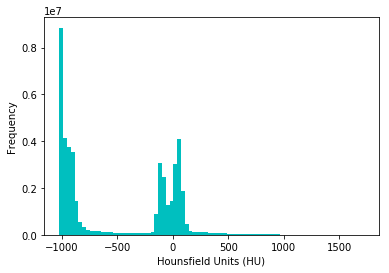

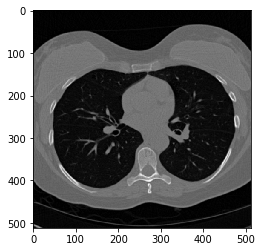

In [8]:
from random import randint
rnd_num = randint(0,len(patients))
id = rnd_num
print ("ID = ", id)
scan = load_scan(INPUT_FOLDER + patients[rnd_num])
scan_pixels = get_pixels_hu(scan)
print ("Total number of slices = ", len(scan))

# Plot a histogram of HU values:
plt.hist(scan_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show the middle slice
plt.imshow(scan_pixels[int(len(scan)/2)], cmap=plt.cm.gray)
#plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)
plt.show()

# Save the raw pixel values
imgs = scan_pixels
output_path = "./kaggle/output/"
np.save(output_path + "scan_pixels_%d.npy" % (id), imgs)

Looking at the table from Wikipedia and the histogram plot, clearly help us distinguish from pixels correspoding to air and tissue structures. 

This information is also used for lung segmentation.


----------

## Stacked plot:

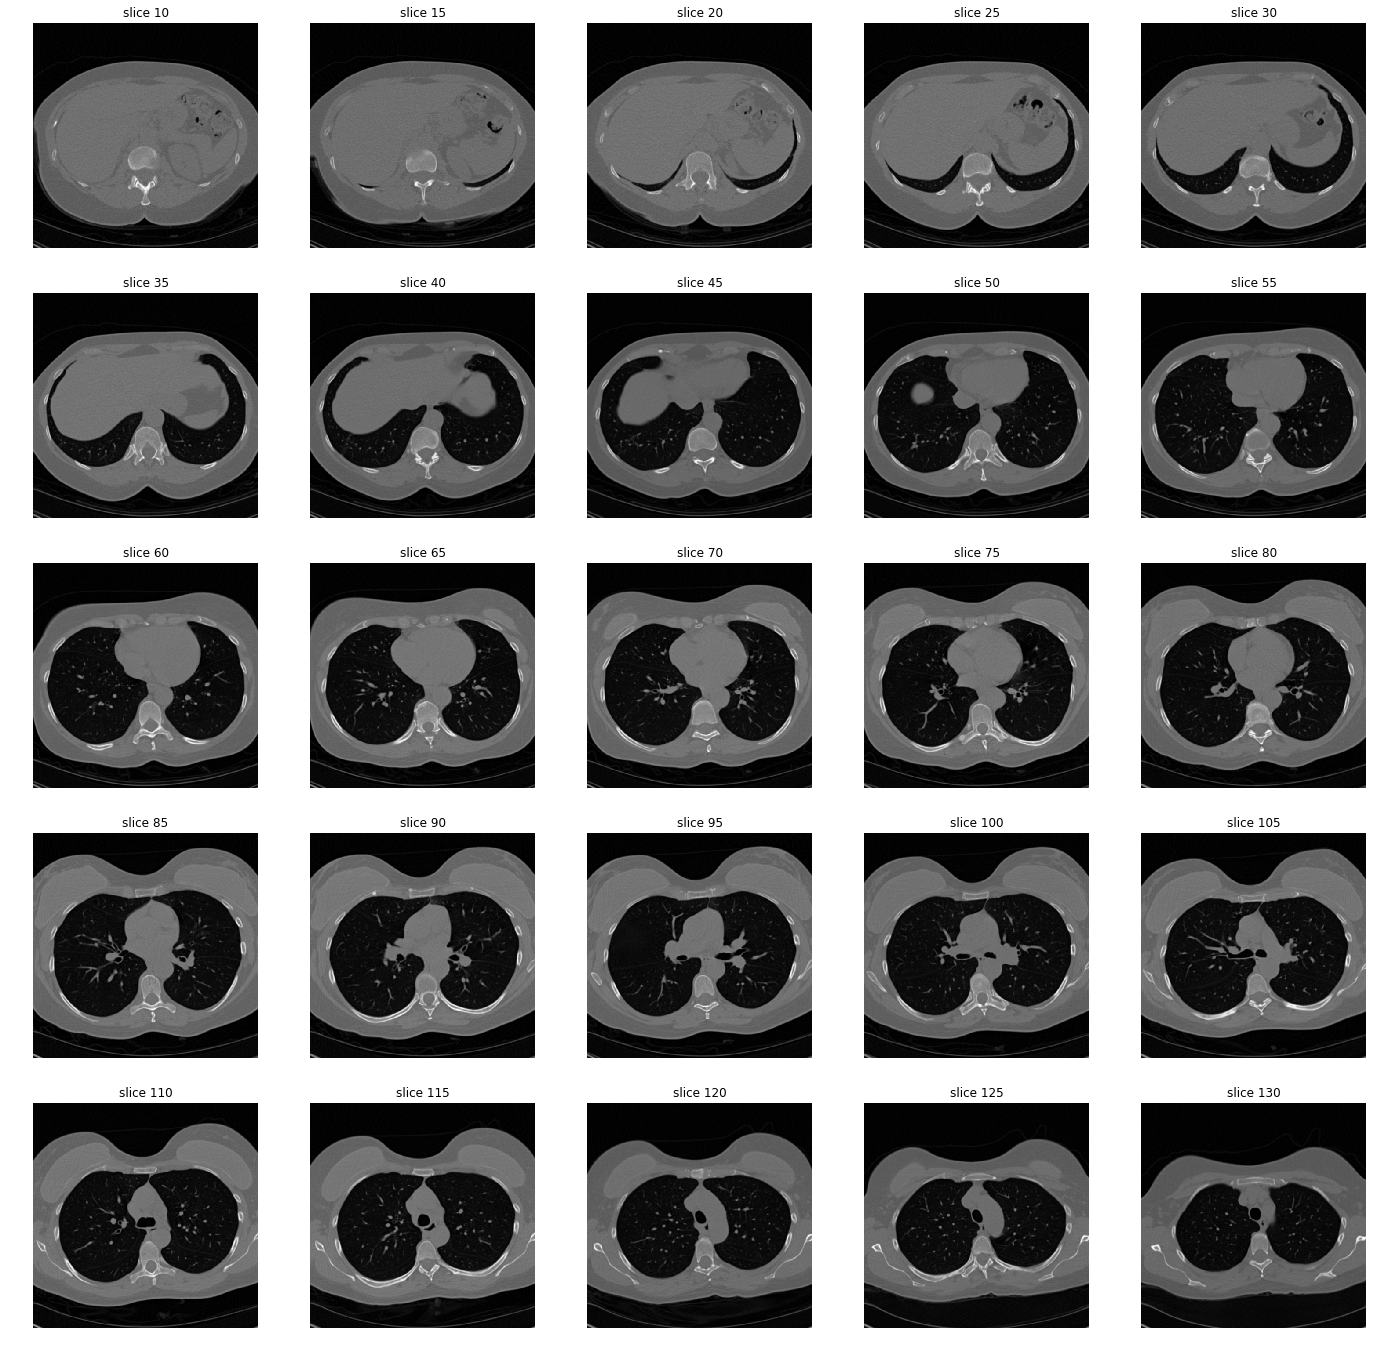

In [9]:
# Generate a stacked summary plot of the scan:

imgs_to_process = np.load(output_path+'scan_pixels_{}.npy'.format(id))

stack_size = 5   # Dimension of the image stack: n x n
start_img = 10   # Starting image for the stack
next_img = 5     # Skip n-1 before plotting the next image

def stack_plot(stack, stack_size, start_img, next_img):
    rows, cols = stack_size, stack_size
    fig,ax = plt.subplots(rows,cols,figsize=[24,24])
    for i in range(rows*cols):
        ind = start_img + i*next_img
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

stack_plot(imgs_to_process, stack_size, start_img, next_img)


## Resampling:
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [20]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Please note that when you apply this, to save the new spacing! Due to rounding this may be slightly off from the desired spacing (above script picks the best possible spacing with rounding).

Let's resample our patient's pixels to an isomorphic resolution of 1 by 1 by 1 mm.

In [11]:
resampled_scan_pixels, spacing = resample(scan_pixels, scan, [1,1,1])
print("Shape before resampling\t", scan_pixels.shape)
print("Shape after resampling\t", resampled_scan_pixels.shape)

Shape before resampling	 (170, 512, 512)
Shape after resampling	 (340, 300, 300)


## 3D plot using marching cubes:
 
The script below creates a 3d rendering of the resampled scan data. 

This function uses the faster, efficient [Lewiner implementation of the marching cubes algorithm](https://goo.gl/KUbJwb).

The plot function takes a threshold argument.  It can used to selectively plot certain structures, such as only the tissue or only the bones. 

A threhold value of 400 shows only the bones.

(For reference see the Hounsfield unit table above.)

In [36]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plot_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=0.15)
    face_color = [1, 0.7, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((1, 0.7, 0.7))
    plt.show()

## Generate a 3D plot:

Transposing surface
Calculating surface
Drawing


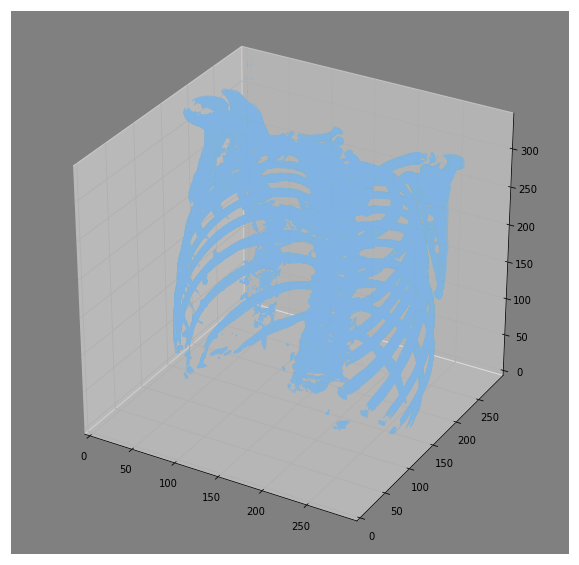

In [19]:
v, f = make_mesh(resampled_scan_pixels, 400)
plot_3d(v, f)

## Lung segmentation - 1

Segmenting the lungs and typically a few surrouding tissue structures help reduce the problem space. The method described here is developed by [Guido Zuidhof and his colleagues](https://goo.gl/sXgKJx). 

This lung segmentation involves quite a few smart steps. It consists of a series of applications of region growing and morphological operations. In this case, we will use only connected component analysis.

The steps are:

* Threshold the image (-320 HU is a good threshold)
* Connected components, determine label of air around person, fill this with 1s in the binary image
* Optionally: For every axial slice in the scan, determine the largest solid connected component (the body and air around the person), and set others to 0. This fills the structures in the lungs in the mask.
* Keep only the largest air pocket (the human body has other pockets of air here and there).

In [21]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [25]:
segmented_lungs = segment_lung_mask(resampled_scan_pixels, False)
segmented_lungs_fill = segment_lung_mask(resampled_scan_pixels, True)

Transposing surface
Calculating surface
Drawing


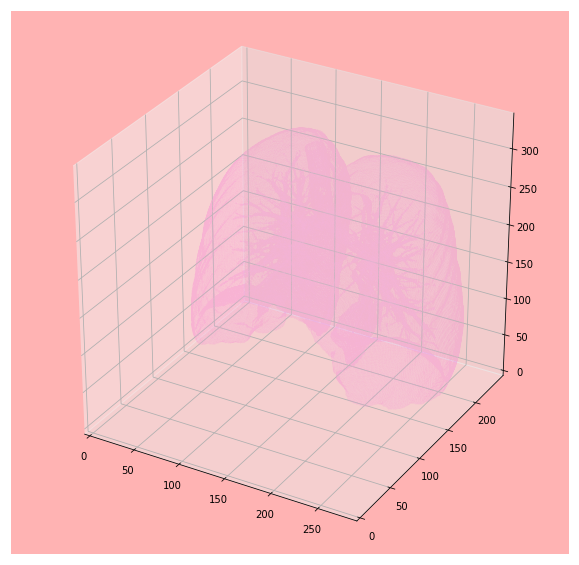

In [37]:
seg_v, seg_f = make_mesh(segmented_lungs, 0, 1)
plot_3d(seg_v, seg_f)

#### Beautiful! 

The next step is to add solid structures inside the lung. Cancerous nodules appear as solid structures inside the lung. Therefore, for a lung cancer detection pipeline, this next step is important. 

Transposing surface
Calculating surface
Drawing


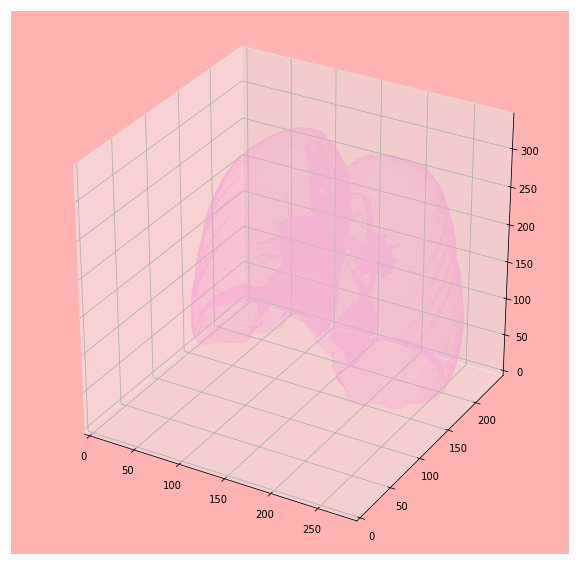

In [38]:
seg_fill_v, seg_fill_f = make_mesh(segmented_lungs_fill, 0, 1)
plot_3d(seg_fill_v, seg_fill_f)

Generate a visualization for the difference between the two masks.

Transposing surface
Calculating surface
Drawing


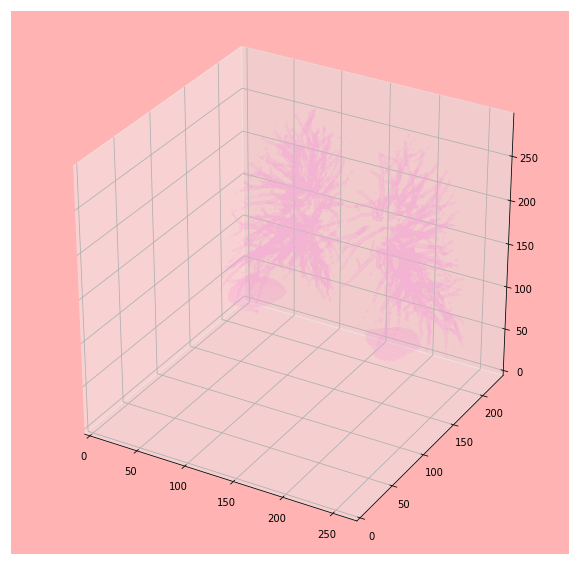

In [39]:
diff_v, diff_f = make_mesh(segmented_lungs_fill - segmented_lungs, 0)
plot_3d(diff_v, diff_f)

## Limitations:


Before applying this mask, **remember to first apply a dilation morphological operation** using a circular kernel.  This expands the mask in all directions. 

The air and the structures in the lung alone will not contain all the lung nodules. The implementation described above in particular it will miss those nodules that are completely surrounded by the lung tissue. A large proportion of the lung cancer nodules often appear in this fashion. Therefore, expand the lung mask to include lung nodules.

**This segmentation will also fail for some edge cases**. The segmentation described above relies on the fact that the air outside the patient is not connected to the air in the lungs. If the patient has a [tracheostomy](https://en.wikipedia.org/wiki/Tracheotomy), this will not be the case. Also, noisy images, those from subjects with implanted devices in the chest cavity like a pacemaker in the image below, this segmentation method will fail. 

Instead, the second largest air pocket in the body will be segmented. An user can recognize this by checking the fraction of image that the mask corresponds to, which will be very small for this case. One can then first apply a morphological closing operation with a kernel a few mm in size to close these holes. This modification can make the segmentation work. 

An unmodified mask should not be applied for these types of images described above. 

![pacemaker example][1]


  [1]: http://i.imgur.com/po0eX1L.png

## Lung segmentation - 2:

This segmentation technique is described in detail by [Howard Chen](https://goo.gl/WDmQQ6). This segmentation technique addresses some of the limitations described above.

**The below code will:**

* ** Standardize the pixel value by subtracting the mean and dividing by the standard deviation.**
* ** Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air. **
* ** Using [Erosion](https://en.wikipedia.org/wiki/Erosion_(morphology) and [Dilation](https://en.wikipedia.org/wiki/Dilation_(morphology) which has the net effect of removing tiny features like pulmonary vessels or noise.**
* ** Identify each distinct region as separate image labels (think the magic wand in Photoshop).**
* ** Using bounding boxes for each image label to identify which ones represent lung and which ones represent "every thing else".**
* ** Create the masks for lung fields.**
* ** Apply mask onto the original image to erase voxels outside of the lung fields.**

In [47]:
#Standardize the pixel values
def segment_lung_mask_2(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

## Lung Segmentation - 2 -- Extract a sample layer for plots:

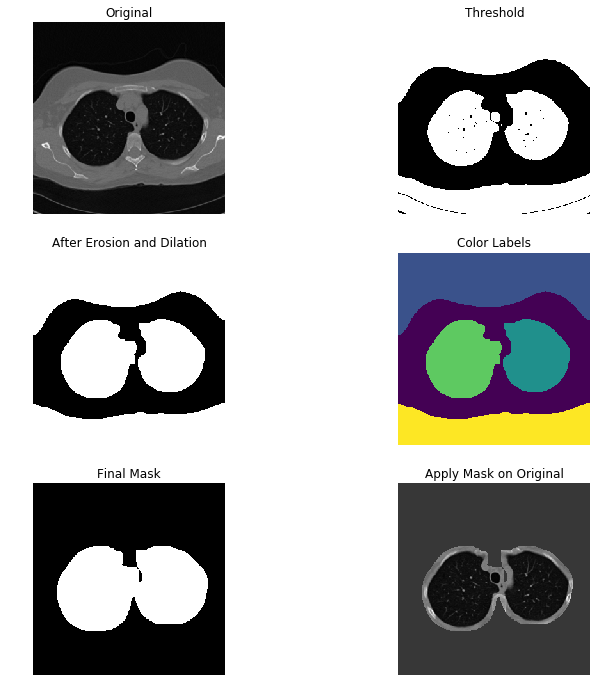

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ..., 
       [-0.,  0.,  0., ..., -0., -0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.]])

In [49]:
test_img = resampled_scan_pixels[260]
segment_lung_mask_2(test_img, display=True)

## Generate segmentaion masks for the entire scan:

The script below iterates through each slice of the scanned image and apply the segmentation mask.

In [55]:
def gen_lung_segmentation_2(imgs):
    masked_lung = []
    for img in imgs:
        masked_lung.append(segment_lung_mask_2(img))
    return masked_lung

segmented_lungs_2 = gen_lung_segmentation_2(resampled_scan_pixels)

## Applying segementation - 2 -- Stacked images:

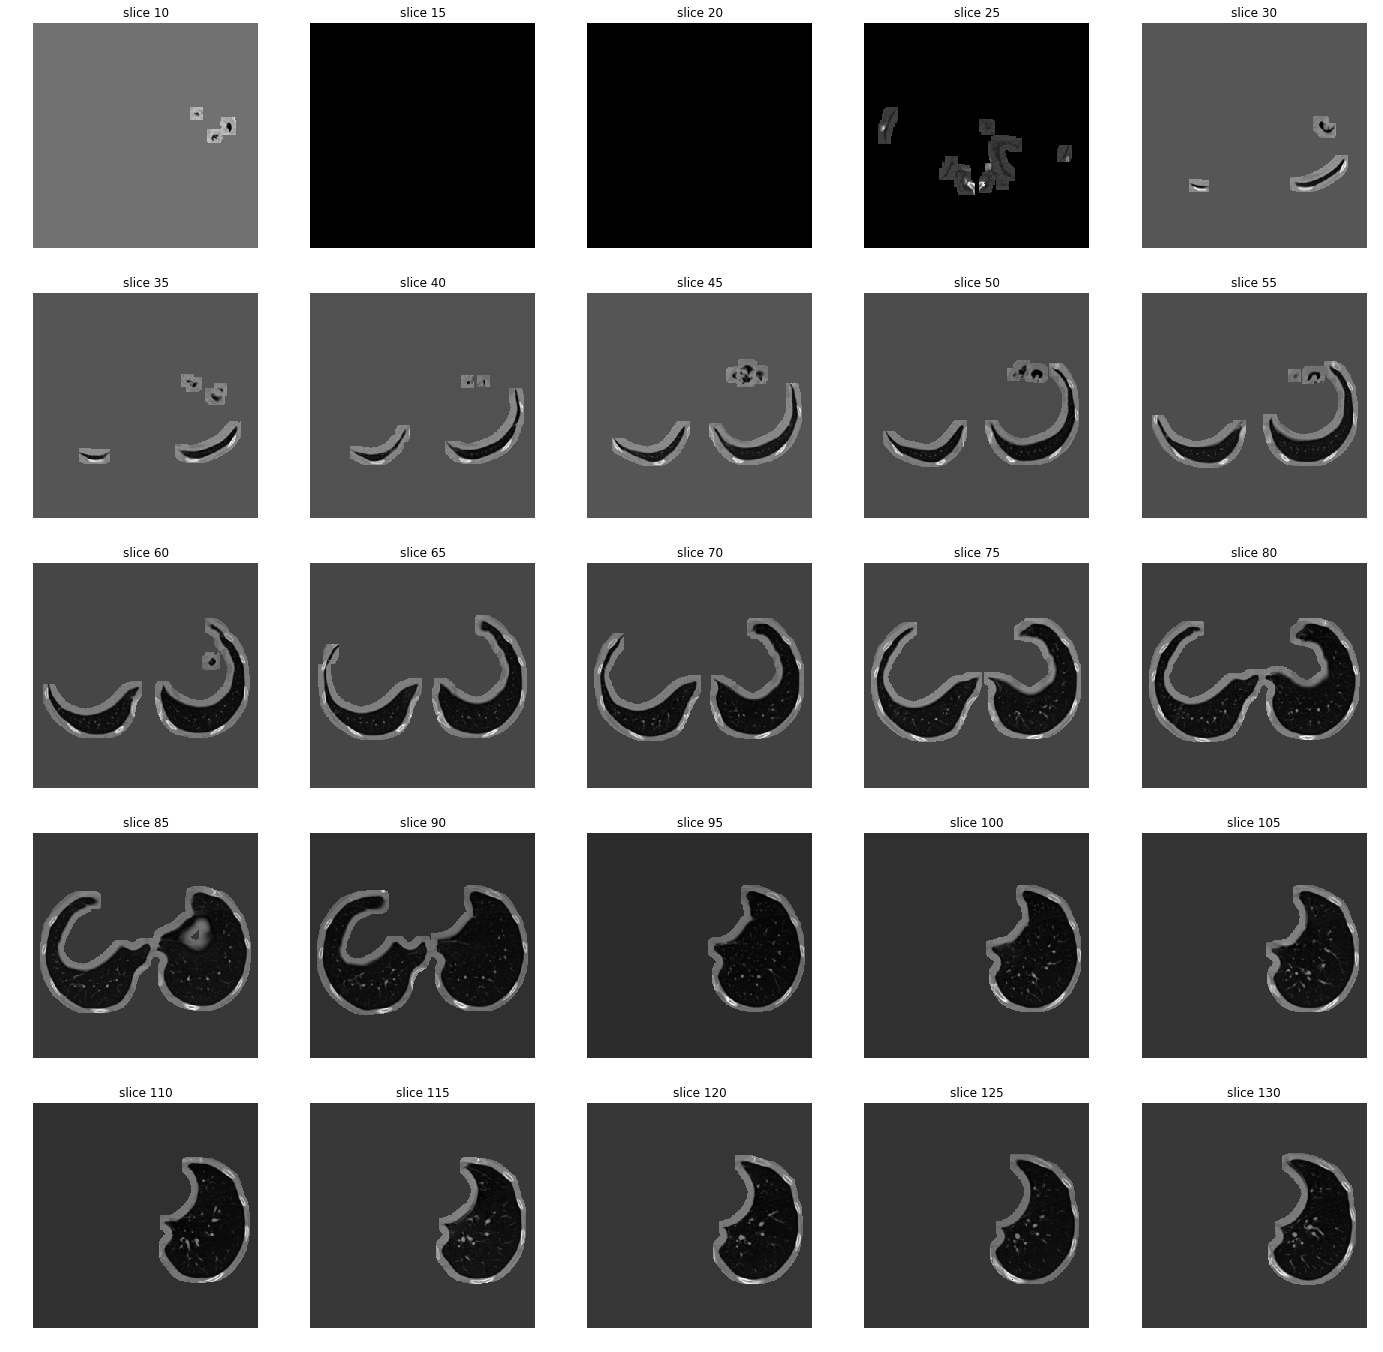

In [61]:
stack_plot(np.array(segmented_lungs_2), stack_size, start_img, 5)

## Lung Segementation - 2 -- Generate a 3D plot:

Transposing surface
Calculating surface
Drawing


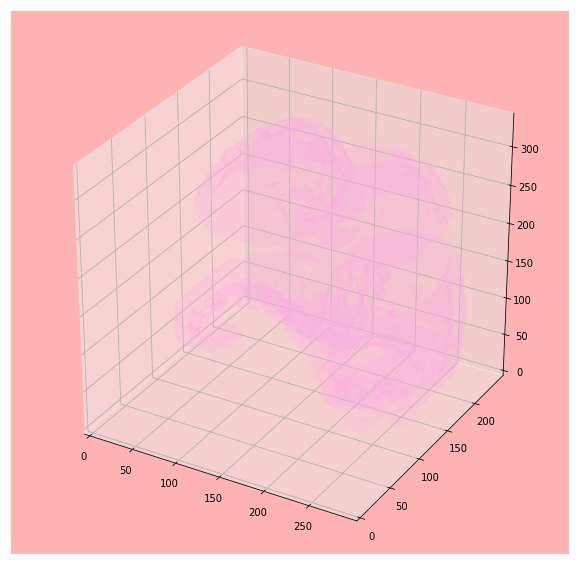

In [59]:
seg_2_v, seg_2_f = make_mesh(np.array(segmented_lungs_2), 0, 8)
plot_3d(seg_2_v, seg_2_f)

Transposing surface
Calculating surface
Drawing


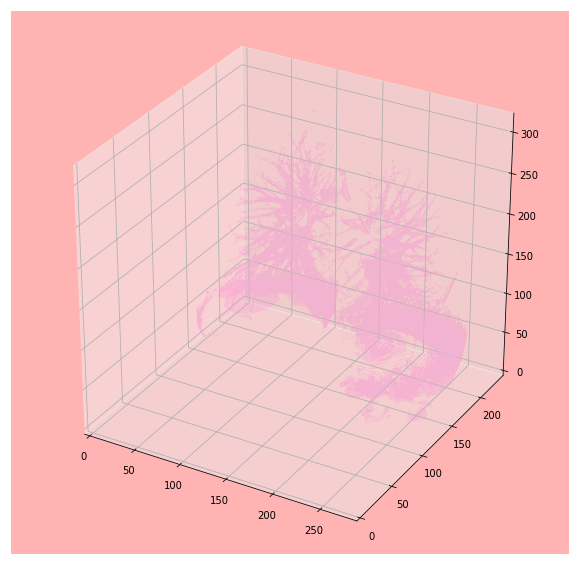

In [78]:
avg_mask = np.array(segmented_lungs_2) + 2*(np.array(segmented_lungs))
diff_2_v , diff_2_f = make_mesh((segmented_lungs_fill - avg_mask), 0, 1)
plot_3d(diff_2_v, diff_2_f)

In [60]:
np.save(output_path + "maskedimages_%d.npy" % (id), segmented_lungs)
np.save(output_path + "maskedimages_2_%d.npy" % (id), np.array(segmented_lungs_2))

## Normalization:

The pixel values currently range from -1024 to around 2000. Anything above 400 is not of importance. These structures are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:

In [14]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

## Zero centering:

As a final preprocessing step, it is advisory to zero center your data so that your mean value is 0. To do this you simply subtract the mean pixel value from all pixels. 

To determine this mean you simply average all images in the whole dataset.  If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition. 

**Warning: Do not zero center with the mean per image (like is done in some kernels on here). The CT scanners are calibrated to return accurate HU measurements. There is no such thing as an image with lower contrast or brightness like in normal pictures.**

In [15]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

## What's next? 

With these steps your images are ready for consumption by your CNN or other ML method :). You can do all these steps offline (one time and save the result), and I would advise you to do so and let it run overnight as it may take a long time. 

**Tip:** To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading). If you don't do this yet, your image are int16's, which are smaller than float32s and easier to compress as well.